# Data Set

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [109]:
df = pd.read_csv("winequality-red.csv")

In [110]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## Transformando a qualidade em binária (Bom = 1 ou Ruim = 0)

In [111]:
def transforma_em_binario(qualidade):
    #https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009
    #Diz para considerar um vinho como bom quando sua nota é maior que 6.5
    return int(qualidade > 6.5)

In [112]:
df.quality = df.quality.apply(lambda x: transforma_em_binario(x))

In [113]:
df.quality.describe()

count    1599.000000
mean        0.135710
std         0.342587
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: quality, dtype: float64

In [114]:
plt.rcParams.update({'font.size': 11})
plt.style.use('bmh')

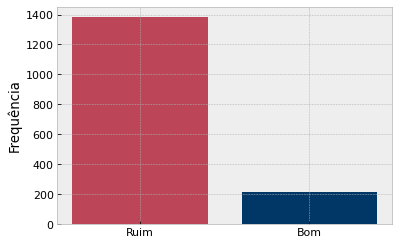

In [115]:
quantidade_bom = df[df.quality.eq(1)].quality.count()
quantidade_ruim = df[df.quality.eq(0)].quality.count()
plt.bar(["Ruim", "Bom"], [quantidade_ruim, quantidade_bom], color = ['#bc4558', '#013766'])
plt.ylabel("Frequência")

plt.savefig("unbalanced.png", dpi = 300, bbox_inches = "tight")

plt.show()

In [116]:
X = df.drop(columns=["quality"])
y = df.quality

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Tratando Dados Desbalanceados 

## Undersampling

In [118]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss, OneSidedSelection

# Random Under Sampler
rus = RandomUnderSampler(random_state=0)
X_rus_res, y_rus_res = rus.fit_resample(X, y)

# NearMiss
nm = NearMiss(version=1)
X_nm_res, y_nm_res = nm.fit_resample(X, y)

# OneSidedSelection (Algoritmo tipo KNN)
oss = OneSidedSelection(random_state=0)
X_oss_res, y_oss_res = oss.fit_resample(X, y)

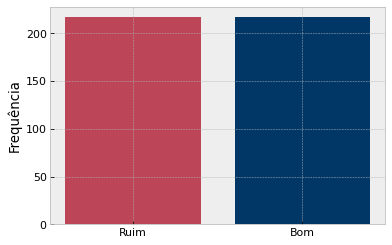

In [119]:
quantidade_bom = y_rus_res[y_rus_res.eq(1)].count()
quantidade_ruim = y_rus_res[y_rus_res.eq(0)].count()
plt.bar(["Ruim", "Bom"], [quantidade_ruim, quantidade_bom], color = ['#bc4558', '#013766'])
plt.ylabel("Frequência")

plt.savefig("undersample.png", dpi = 300, bbox_inches = "tight")

plt.show()

## Oversampling

In [159]:
from sklearn import svm
from sklearn.metrics import matthews_corrcoef, make_scorer, f1_score, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, cross_validate

# Treinando e Avaliando Modelo com MCC:
clf = svm.SVC()
clf.fit(X_train, y_train)
scoring = make_scorer(matthews_corrcoef)
y_pred = clf.predict(X_test)
print("MCC: ", round(matthews_corrcoef(y_test, y_pred), 4))
print("F1: ", round(f1_score(y_test, y_pred), 4))
print("ACC: ", round(accuracy_score(y_test, y_pred), 4))

MCC:  0.1349
F1:  0.0417
ACC:  0.8562


In [158]:
from imblearn.over_sampling import RandomOverSampler

# Resample:
ros = RandomOverSampler(random_state = 32)
X_ros_res, y_ros_res = ros.fit_resample(X, y)
# Treinando e Avaliando Modelo:
clf = svm.SVC()
scoring = {'mcc': make_scorer(matthews_corrcoef), 'f1':'f1', 'acc': 'accuracy'}
results_ros = cross_validate(clf.fit(X_ros_res, y_ros_res),
                             X_ros_res, y_ros_res,
                             cv=5, scoring=scoring)
print("MCC: ", round(results_ros['test_mcc'].mean(), 4))
print("F1: ", round(results_ros['test_f1'].mean(), 4))
print("ACC: ", round(results_ros['test_acc'].mean(), 4))

MCC:  0.4377
F1:  0.7413
ACC:  0.7131


In [122]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Resample:
ros = RandomOverSampler(random_state = 32)
X_ros_res, y_ros_res = ros.fit_resample(X, y)

smote = SMOTE(random_state = 32)
X_smote_res, y_smote_res = smote.fit_resample(X, y)

In [160]:
from imblearn.over_sampling import SMOTE

# Resample:
smote = SMOTE(random_state = 32)
X_smote_res, y_smote_res = smote.fit_resample(X, y)
# Treinando e Avaliando Modelo:
clf = svm.SVC()
scoring = {'f1':'f1', 'mcc': make_scorer(matthews_corrcoef), 'acc': 'accuracy'}
results_smote = cross_validate(clf.fit(X_smote_res, y_smote_res),
                               X_smote_res, y_smote_res,
                               cv=5, scoring=scoring)
print("MCC: ", round(results_smote['test_mcc'].mean(), 4))
print("F1: ", round(results_smote['test_f1'].mean(), 4))
print("ACC: ", round(results_smote['test_acc'].mean(), 4))

MCC:  0.4671
F1:  0.7547
ACC:  0.7279


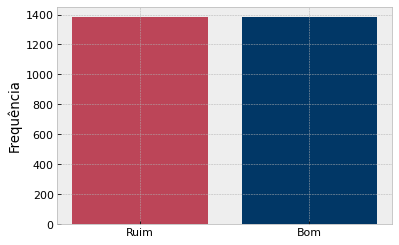

In [124]:
quantidade_bom = y_ros_res[y_ros_res.eq(1)].count()
quantidade_ruim = y_ros_res[y_ros_res.eq(0)].count()
plt.bar(["Ruim", "Bom"], [quantidade_ruim, quantidade_bom], color = ['#bc4558', '#013766'])
plt.ylabel("Frequência")

plt.savefig("oversample.png", dpi = 300, bbox_inches = "tight")

plt.show()